In [ ]:
!git clone https://github.com/drmz09520/exlr.git
%cd exlr
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install -r /content/exlr/requirements.txt

In [ ]:
!wget --content-disposition https://huggingface.co/BixBit11/DarkRevPikas/resolve/main/DarkRevPikas_v30_pruned.safetensors?download=true

In [ ]:
!wget https://huggingface.co/fp16-guy/anything_kl-f8-anime2_vae-ft-mse-840000-ema-pruned_blessed_clearvae_fp16_cleaned/resolve/main/kl-f8-anime2_fp16.safetensors?download=true

In [ ]:
!wget -O /content/animesharpx4.pth https://huggingface.co/krauzerh/animesharpx4/resolve/main/4x-AnimeSharp.pth?download=true

In [1]:
%cd exlr
!python main.py --highvram

/content/exlr
Traceback (most recent call last):
  File "/content/exlr/main.py", line 10, in <module>
    model_file = comfy.sd.load_checkpoint_guess_config(ckpt_path, output_vae=True, output_clip=True, embedding_directory="/content/")
NameError: name 'comfy' is not defined


In [2]:
def common_ksampler(model, seed, steps, cfg, sampler_name, scheduler, positive, negative, latent, denoise=1.0, disable_noise=False, start_step=None, last_step=None, force_full_denoise=False):
    latent_image = latent["samples"]
    if disable_noise:
        noise = torch.zeros(latent_image.size(), dtype=latent_image.dtype, layout=latent_image.layout, device="cpu")
    else:
        batch_inds = latent["batch_index"] if "batch_index" in latent else None
        noise = comfy.sample.prepare_noise(latent_image, seed, batch_inds)

    noise_mask = None
    if "noise_mask" in latent:
        noise_mask = latent["noise_mask"]

    # callback = latent_preview.prepare_callback(model, steps)
    callback = None
    disable_pbar = not comfy.utils.PROGRESS_BAR_ENABLED
    samples = comfy.sample.sample(model, noise, steps, cfg, sampler_name, scheduler, positive, negative, latent_image,
                                  denoise=denoise, disable_noise=disable_noise, start_step=start_step, last_step=last_step,
                                  force_full_denoise=force_full_denoise, noise_mask=noise_mask, callback=callback, disable_pbar=disable_pbar, seed=seed)
    out = latent.copy()
    out["samples"] = samples
    return out

# create empty latent
def generate(width, height, batch_size=1):
    device = comfy.model_management.intermediate_device()
    latent = torch.zeros([batch_size, 4, height // 8, width // 8], device=device)
    return {"samples":latent}

def encode_clip(clip, text):
    tokens = clip.tokenize(text)
    cond, pooled = clip.encode_from_tokens(tokens, return_pooled=True)
    return [[cond, {"pooled_output": pooled}]]

def set_last_layer(clip, stop_at_clip_layer):
    clip = clip.clone()
    clip.clip_layer(stop_at_clip_layer)
    return clip

upscale_methods = ["nearest-exact", "bilinear", "area", "bicubic", "bislerp"]

def latent_upscale(samples, upscale_method, scale_by):
    s = samples.copy()
    width = round(samples["samples"].shape[3] * scale_by)
    height = round(samples["samples"].shape[2] * scale_by)
    s["samples"] = comfy.utils.common_upscale(samples["samples"], width, height, upscale_method, "disabled")
    return s

def upscale_w_model(upscale_model, image):
  device = comfy.model_management.get_torch_device()
  upscale_model.to(device)
  in_img = image.movedim(-1,-3).to(device)
  free_memory = comfy.model_management.get_free_memory(device)

  tile = 512
  overlap = 32

  oom = True
  while oom:
      try:
          steps = in_img.shape[0] * comfy.utils.get_tiled_scale_steps(in_img.shape[3], in_img.shape[2], tile_x=tile, tile_y=tile, overlap=overlap)
          pbar = comfy.utils.ProgressBar(steps)
          s = comfy.utils.tiled_scale(in_img, lambda a: upscale_model(a), tile_x=tile, tile_y=tile, overlap=overlap, upscale_amount=upscale_model.scale, pbar=pbar)
          oom = False
      except comfy.model_management.OOM_EXCEPTION as e:
          tile //= 2
          if tile < 128:
              raise e

  upscale_model.cpu()
  s = torch.clamp(s.movedim(-3,-1), min=0, max=1.0)
  return s.clone()


def load_model(model_path):
    sd = comfy.utils.load_torch_file(model_path, safe_load=True)
    if "module.layers.0.residual_group.blocks.0.norm1.weight" in sd:
        sd = comfy.utils.state_dict_prefix_replace(sd, {"module.":""})
    out = model_loading.load_state_dict(sd).eval()
    return out

def upscale_image_by(image, upscale_method, scale_by):
    samples = image.movedim(-1,1)
    width = round(samples.shape[3] * scale_by)
    height = round(samples.shape[2] * scale_by)
    s = comfy.utils.common_upscale(samples, width, height, upscale_method, "disabled")
    s = s.movedim(1,-1)
    return s.clone()


In [4]:
#@title setup prompt

p_text = "photorealistic, (hyperrealistic:1.2), beautiful, masterpiece, best quality, extremely detailed face, dress, perfect lighting, full body, large breasts, wide hips, thick thighs, plump, detailed eye makeup, detail face, nice detailed eyes, heavy eye makeup, white hair, purple eyes, white_legwear, (detached_sleeves:1.2), emilia \\(re:zero\\), emilia \\(re:zero\\), (light white short hair), detailed hands and fingers, white flower, green chest jewel, nature, landscape, mountains, medieval, scenery, falling petals, flowers," # @param {type:"string"}
n_text = "(worst quality, low quality:1.3), (monochrome), zombie, watermark, username,patreon username, patreon logo, (extra fingers, deformed hands, polydactyl:1.2)" # @param {type:"string"}
clip_skip = -2 # @param {type:"integer"}
clip_layer = set_last_layer(clip, clip_skip)

positive = encode_clip(clip_layer, p_text)
negative = encode_clip(clip_layer, n_text)

NameError: name 'model_file' is not defined

In [4]:
#@title create empty latent

height = 704 # @param {type:"integer"}
width = 512 # @param {type:"integer"}

latent = generate(width, height, 1)

In [6]:
from comfy.sd import VAE

vae_file = comfy.utils.load_torch_file("/content/klvae.safetensors")

vae = VAE(sd=vae_file)

denoise = 1.0
disable_noise = False
start_step = None
last_step = None
force_full_denoise = False
seed = 1828262939
steps = 20
cfg = 7.0
sampler_name = comfy.samplers.KSampler.SAMPLERS[1]
scheduler = comfy.samplers.KSampler.SCHEDULERS[0]

a = common_ksampler(model, seed, steps, cfg, sampler_name, scheduler, positive, negative, latent, denoise, disable_noise, start_step, last_step, force_full_denoise)

# b = latent_upscale(a, upscale_methods[0], 1.5)

b = vae.decode(a["samples"])

# upscale_model = load_model("/content/animesharpx4.pth")

# c = upscale_w_model(upscale_model, b)

# d = upscale_image_by(c, upscale_methods[0], 0.5)

e = vae.encode(b)

# y = common_ksampler(model, seed, steps, cfg, sampler_name, scheduler, positive, negative, e, 0.7, disable_noise, start_step, last_step, force_full_denoise)


  0%|          | 0/20 [00:00<?, ?it/s]

Requested to load AutoencoderKL
Loading 1 new model


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 9.06 MiB is free. Process 184822 has 14.74 GiB memory in use. Of the allocated memory 14.51 GiB is allocated by PyTorch, and 96.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

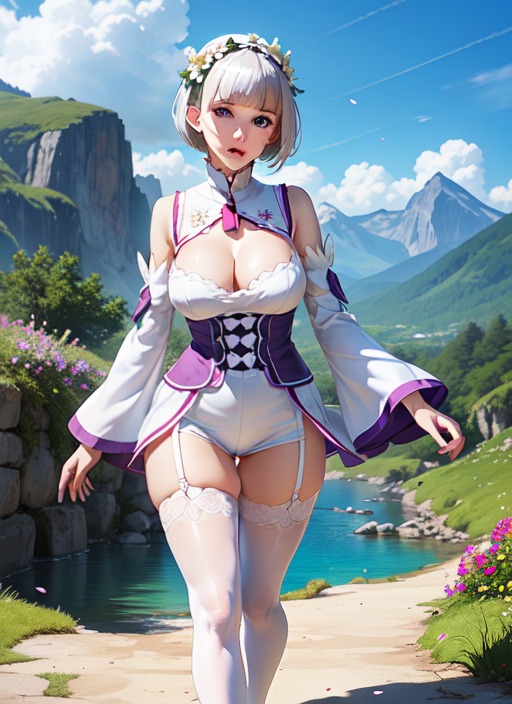

NameError: name 'c' is not defined

In [25]:
# decoded_img = vae.decode_tiled(b["samples"])

x = y.detach().squeeze(0)

i = 255. * x.cpu().numpy()

img = np.clip(i, 0, 255).astype(np.uint8)

# Convert from BGR to RGB
img = img[:, :, ::-1]

cv2_imshow(img)

del c
del x
del i
del img

torch.cuda.empty_cache()

comfy.model_management.cleanup_models()
comfy.model_management.unload_all_models()